# Image classification from scratch

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/04/27<br>
**Last modified:** 2020/04/28<br>
**Description:** Training an image classifier from scratch on the Kaggle Cats vs Dogs dataset.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Load the data: the Cats vs Dogs dataset

### Raw data download

First, let's download the 786M ZIP archive of the raw data:


In [ ]:
# !curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


In [ ]:
# !unzip -q kagglecatsanddogs_3367a.zip
# !ls


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [6]:
!ls PetImages


Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [13]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 0 images


## Generate a `Dataset`


In [13]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


## Visualize the data

Here are the first 9 images in the training dataset. As you can see, label 1 is "dog"
 and label 0 is "cat".


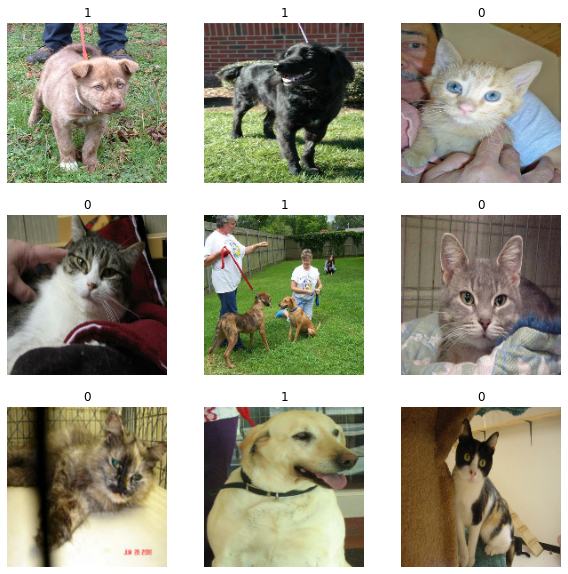

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [16]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the augmented samples look like, by applying `data_augmentation`
 repeatedly to the first image in the dataset:


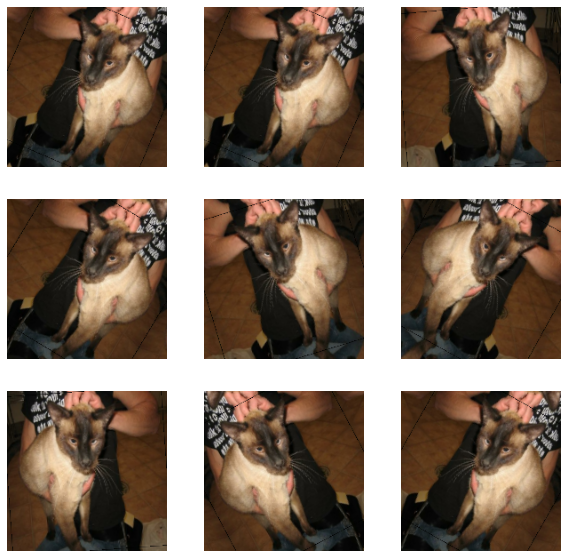

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our image are already in a standard size (180x180), as they are being yielded as
contiguous `float32` batches by our dataset. However, their RGB channel values are in
 the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of
 our model.


## Two options to preprocess the data

There are two ways you could be using the `data_augmentation` preprocessor:

**Option 1: Make it part of the model**, like this:

```python
inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(x)
...  # Rest of the model
```

With this option, your data augmentation will happen *on device*, synchronously
with the rest of the model execution, meaning that it will benefit from GPU
 acceleration.

Note that data augmentation is inactive at test time, so the input samples will only be
 augmented during `fit()`, not when calling `evaluate()` or `predict()`.

If you're training on GPU, this is the better option.

**Option 2: apply it to the dataset**, so as to obtain a dataset that yields batches of
 augmented images, like this:

```python
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))
```

With this option, your data augmentation will happen **on CPU**, asynchronously, and will
 be buffered before going into the model.

If you're training on CPU, this is the better option, since it makes data augmentation
 asynchronous and non-blocking.

In our case, we'll go with the first option.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [14]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)


## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [19]:
'''
Note:
Each layer (e,g,. layers.Conv2D(32, 3, strides=2, padding="same")(x) )
is a set of function(s) which map input (x) into different spaces:

1. Use BatchNormalization() to solve gradient vanish and Internal Covariate Shift (ICS) 

2. Residual structure (ResNet) to solve degradation problem

3. Use SeparableConv2D to build a light-weight (computational cost) inception block
https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2
Depth-wise conv following by a set of point-wise conv (according to the number of filter) 


'''


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    # x.shape: (None, 180, 180, 3)
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)  # rescaling 縮放
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)  # padding = same 自動補0
    # padding="same": dim = ceil(o_dim/strides), channel=num_filter
    # padding="valid": dim = ceil(o_dim-f_dim+1/strides), channel=num_filter
    # x.shape: (None, 90, 90, 32)   90 = 180 / strides  32 = 自己取的fliter
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same")(x)    
    # x.shape: (None, 90, 90, 64)  因為沒給strides  所以就是1  90/1 =90  64則是自己給定
    
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual 先存

    for size in [128, 256, 512, 728]:
        
        # x.shape: (None, 90, 90, 64) (1st loop/block)
        # x.shape: (None, 45, 45, 128) (2nd loop/block)
        # x.shape: (None, 23, 23, 256) (3nd loop/block)
        # x.shape: (None, 12, 12, 512) (3nd loop/block)
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # x.shape: (None, 90, 90, 128) (1st loop/block)
        # x.shape: (None, 45, 45, 256) (2nd loop/block)
        # x.shape: (None, 23, 23, 512) (3nd loop/block)
        # x.shape: (None, 12, 12, 728) (3nd loop/block)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        # x.shape: (None, 90, 90, 128) (1st loop/block)
        # x.shape: (None, 45, 45, 256) (2nd loop/block)
        # x.shape: (None, 23, 23, 512) (3nd loop/block)
        # x.shape: (None, 12, 12, 728) (3nd loop/block)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # x.shape: (None, 45, 45, 128) (1st loop/block)
        # x.shape: (None, 23, 23, 256) (2nd loop/block)
        # x.shape: (None, 12, 12, 512) (3nd loop/block)
        # x.shape: (None,   6, 6, 728) (3nd loop/block)

        # Project residual
        # point-wise (1x1) conv on previous_block_activation
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)  # 對每個channal做平均池化
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 90, 90, 32)   896         rescaling[0][0]                  
_______________________________________________________________________________________

## Train the model


In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),    # 
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/20
586/586 [==============================] - 2208s 4s/step - loss: 0.6201 - accuracy: 0.6705 - val_loss: 0.5225 - val_accuracy: 0.7522
Epoch 2/20
586/586 [==============================] - 2151s 4s/step - loss: 0.4695 - accuracy: 0.7775 - val_loss: 0.7387 - val_accuracy: 0.7003
Epoch 3/20
586/586 [==============================] - 2015s 3s/step - loss: 0.3748 - accuracy: 0.8331 - val_loss: 0.3437 - val_accuracy: 0.8507
Epoch 4/20
502/586 [========================>.....] - ETA: 5:32 - loss: 0.3042 - accuracy: 0.8665

We get to ~96% validation accuracy after training for 50 epochs on the full dataset.


## Run inference on new data

Note that data augmentation and dropout are inactive at inference time.


In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)


## Exercise: use pre-trained models

In [15]:
# https://keras.io/api/applications/
# http://www.image-net.org/

from tensorflow.keras.applications import EfficientNetB7
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [16]:
pt_model =EfficientNetB7(weights='imagenet')
pt_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 600, 600, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 600, 600, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 600, 600, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 601, 601, 3)  0           normalization_3[0][0]            
_____________________________________________________________________________________

In [17]:
pt_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=image_size + (3,))
pt_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 180, 180, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 180, 180, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 181, 181, 3)  0           normalization_4[0][0]            
_____________________________________________________________________________________

In [21]:
# from tensorflow.keras.applications import preprocess_input 
# from tensorflow.keras.applications.xception 


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
#     x = preprocess_input(inputs)
    x = pt_model(inputs)  # 把處理好的output 來當這邊的input
    
    x = layers.GlobalAveragePooling2D()(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [22]:
pt_model = make_model(input_shape=image_size + (3,), num_classes=2)
# keras.utils.plot_model(model, show_shapes=True)
pt_model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
efficientnetb7 (Functional)  (None, 6, 6, 2560)        64097687  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2561      
Total params: 64,100,248
Trainable params: 63,789,521
Non-trainable params: 310,727
_________________________________________________________________


In [23]:
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
pt_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

for layer in pt_model.layers[:-1]:
   layer.trainable = False
for layer in pt_model.layers[-1:]:
   layer.trainable = True

pt_model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/3


ResourceExhaustedError:  OOM when allocating tensor with shape[32,45,45,288] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[node functional_1/efficientnetb7/block2e_bn/FusedBatchNormV3 (defined at <ipython-input-23-2aa3d967acbe>:17) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_157153]

Function call stack:
train_function
